In [157]:
import requests
import plotly
import matplotlib.pyplot as plt
# from pylab import mpl, plt
import numpy as np
import yfinance as yf
import os
import sys
import pandas as pd
from scipy.stats import pearsonr
from datetime import datetime
from dateutil.relativedelta import relativedelta
from configparser import ConfigParser
import nasdaqdatalink

In [158]:
plt.style.use('seaborn')

https://aroussi.com/post/python-yahoo-finance

# Global Vars

In [159]:
blue_chip_stocks = [
    'DIS',
    'AAPL',
    'AXP',
    'BAC',
    'C',
    'CAT',
    'MCD',
    'MMM',
    'WMT',
    'GS',
    'MSFT'
]

In [272]:
DT_STATIC = datetime(2023,9,29)
DT_PRIOR = DT_STATIC - relativedelta(years=5) # prior x years

In [243]:
config = ConfigParser()
config.read('./config.ini')

['./config.ini']

In [244]:
# INITIALIZE API Key
nasdaqdatalink.ApiConfig.api_key = config['APIKeys']['quandl']

# SMA

In [280]:
class SMABacktester:
    def __init__(self, name):
        self.ticker = name
        self.obj = yf.Ticker(name)
        self.data = self.obj.history(start=DT_PRIOR, end=DT_STATIC)\
            .reset_index().sort_values('Date', ascending=True)
        self.data.Date = pd.to_datetime(self.data.Date)
        self.data = self.data.set_index('Date')
        self.info = self.obj.info

    def set_parameters(self, sma_low, sma_high):
        self.sma_low = sma_low
        self.sma_high = sma_high
        self.data['SMA_Low'] = self.data['Close'].rolling(sma_low).mean()
        self.data['SMA_High'] = self.data['Close'].rolling(sma_high).mean()
        self.data.dropna(inplace=True) # drop data if it doesn't have all SMAs
    
    def run_strategy(self):
        # get returns
        self.data['returns'] = np.log(self.data['Close'] / self.data['Close'].shift(1))

        # get strategy POSITION
        self.data['position'] = np.where(self.data['SMA_Low'] > self.data['SMA_High'], 1, 0)

        # get log returns of strategy
        self.data['strategy_returns'] = self.data['position'].shift(1) * self.data['returns']

        # get cumulative returns
        self.data['strategy_cumret'] = self.data['strategy_returns'].cumsum().apply(np.exp)

        # get cumulative max up until a certain point
        self.data['strategy_cummax'] = self.data['strategy_cumret'].cummax()
    
    def get_backtest_metrics(self):
        metrics = dict()
        
        # get cumulative returns
        metrics['cum_returns'] = np.exp(self.data['returns'].sum())-1
        metrics['strategy_cum_returns'] = np.exp(self.data['strategy_returns'].sum())-1

        # get annualized returns
        metrics['annualized_returns'] = np.exp(self.data['returns'].mean()*252)-1
        metrics['annualized_strategy_returns'] = np.exp(self.data['strategy_returns'].mean()*252)-1

        # get get annualized standard deviation
        metrics['annualized_std'] = (self.data['returns'].apply(np.exp)-1).std()*252**0.5
        metrics['annualized_strategy_std'] = (self.data['strategy_returns'].apply(np.exp)-1).std()*252**0.5

        # max drawdown
        drawdown = self.data.strategy_cummax - self.data.strategy_cumret
        metrics['max_drawdown'] = drawdown.max()

        # longest drawdown
        zero_drawdown = drawdown[drawdown == 0]
        # get periods by shifting the drawdown dates over one and subtracting it from the prior
        periods = (zero_drawdown.index[1:].to_pydatetime() - zero_drawdown.index[:-1].to_pydatetime()) 
        metrics['longest_drawdown'] = periods.max() # get the longest period

        # return data
        return metrics
    
    def plot_results(self):
        # price plot
        
        plt.plot(self.data.index, self.data.Close, label='Close Price')
        plt.plot(self.data.index, self.data.SMA_Low, label=f'SMA {self.sma_low}')
        plt.plot(self.data.index, self.data.SMA_High, label=f'SMA {self.sma_high}')
        plt.legend()
        plt.title('Close Price & SMA')
        plt.xlabel('Date')
        plt.show()
        plt.clf()
        
        # market positioning
        plt.plot(self.data.index, self.data.position, label='position')
        plt.legend()
        plt.title('Market Positioning')
        plt.xlabel('Date')
        plt.show()
        plt.clf()

        # histogram of log returns
        plt.hist(self.data['returns'], bins=35)
        plt.title('SPY Log Returns')
        plt.show()
        plt.clf()

        # cumulative returns
        plt.plot(self.data.index, self.data.returns.cumsum().apply(np.exp), label='Returns Hold')
        plt.plot(self.data.index, self.data.strategy_returns.cumsum().apply(np.exp), label='Returns Strategy')
        plt.legend()
        plt.title('Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.show()
        plt.clf()

        # drawdown
        plt.plot(self.data.index, self.data.strategy_cumret, label='Cumulative Return')
        plt.plot(self.data.index, self.data.strategy_cummax, label='Cumulative Max Return')
        plt.title('Drawdown Visualization')
        plt.legend()
        plt.title('Drawdown')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.show()
        plt.clf()

In [286]:
obj_spy = SMABacktester('UBS')

In [291]:
obj_spy.set_parameters(60, 252)

In [292]:
obj_spy.run_strategy()

In [293]:
obj_spy.get_backtest_metrics()

{'cum_returns': 1.4844965426897856,
 'strategy_cum_returns': 0.9835594865185069,
 'annualized_returns': 0.35548773256593647,
 'annualized_strategy_returns': 0.25722035237181085,
 'annualized_std': 0.3179043727820372,
 'annualized_strategy_std': 0.27750873682609856,
 'max_drawdown': 0.6067808993009962,
 'longest_drawdown': datetime.timedelta(days=568)}

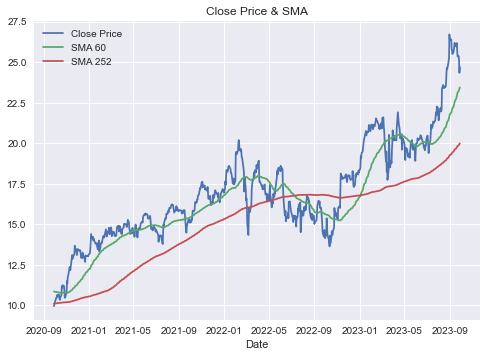

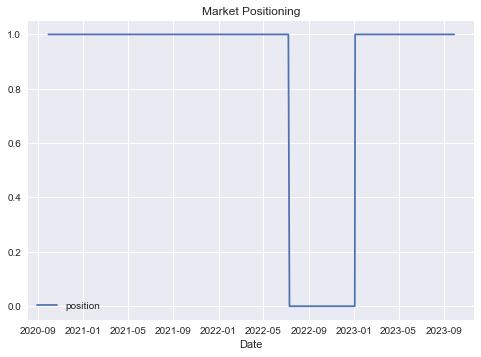

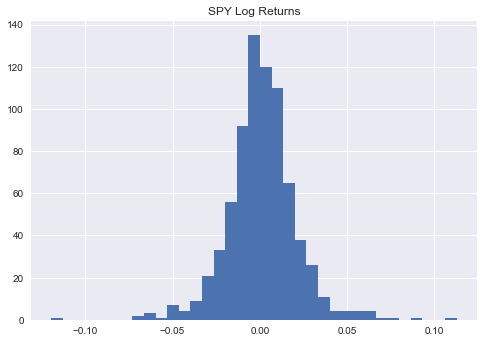

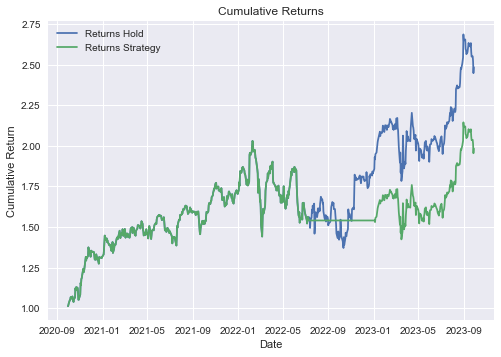

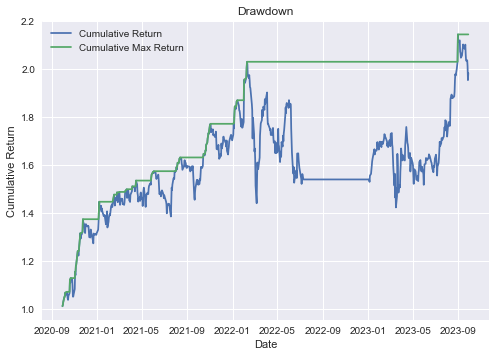

<Figure size 576x396 with 0 Axes>

In [294]:
obj_spy.plot_results()

# Momentum